In [1]:
%load_ext autoreload
%autoreload 2

import os
import pathlib

import dask
import xarray as xr
import matplotlib.pyplot as plt

from mjonet import era5

from cartopy import crs as ccrs
from dask.distributed import Client, LocalCluster

USER = os.environ['USER']

if os.environ['NERSC_HOST'] == 'perlmutter':
    SCRATCH = f'/pscratch/sd/{USER[0]}/{USER}/'
else:
    SCRATCH = f'/global/cscratch1/sd/{USER}/'

weights_dir = os.path.join(SCRATCH, 'data/era5/regridder_weights')

if not os.path.exists(weights_dir):
    pathlib.Path(weights_dir).mkdir(parents=True, exist_ok=True)

In [2]:
%%time

glob_dict = era5.make_glob_dict(var_names=['mtnlwrf', 'r', 'tcwv'], years=range(1979, 2016))
print(glob_dict['r'][0])
print(glob_dict['r'][-1], '\n')

fpath_dict = era5.get_filepaths(glob_dict)
print(fpath_dict['r'][0])
print(fpath_dict['r'][-1], '\n')

/global/cfs/projectdirs/m3522/cmip6/ERA5/e5.oper.an.pl/1979[0-1][0-9]/e5.oper.an.pl.128_157_r.ll025sc.*.nc
/global/cfs/projectdirs/m3522/cmip6/ERA5/e5.oper.an.pl/2015[0-1][0-9]/e5.oper.an.pl.128_157_r.ll025sc.*.nc 

/global/cfs/projectdirs/m3522/cmip6/ERA5/e5.oper.an.pl/197901/e5.oper.an.pl.128_157_r.ll025sc.1979010100_1979010123.nc
/global/cfs/projectdirs/m3522/cmip6/ERA5/e5.oper.an.pl/201512/e5.oper.an.pl.128_157_r.ll025sc.2015123100_2015123123.nc 

CPU times: user 360 ms, sys: 302 ms, total: 662 ms
Wall time: 688 ms


### Preprocess some of the variables.

In [3]:
%%time

glob_dict = era5.make_glob_dict(var_names=['mtnlwrf', 'r', 'tcwv'], years=[1988])
fpath_dict = era5.get_filepaths(glob_dict)

with LocalCluster(n_workers=8) as cluster, Client(cluster) as client, dask.config.set({'temporary-directory': '/tmp'}):
    dset = era5.preprocess(fpath_dict,
                           plevels={'r': [200, 500]}, 
                           resolution=1.,
                           regridder_weights_dir=weights_dir,
                           chunks={'time': 1},
                           parallel=True, 
                           verbose=True)

dset

Processing 402 files...
Datasets opened and combined. Removing missing times...
var_name: mtnlwrf
var_name: r
var_name: tcwv
Missing times removed. Subsampling and regridding...


/global/homes/j/jpduncan/.conda/envs/mjonet-preproc/lib/python3.9/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/global/homes/j/jpduncan/.conda/envs/mjonet-preproc/lib/python3.9/site-packages/xesmf/frontend.py:594: UserWarning: Using dimensions ('latitude', 'longitude') from data variable MTNLWRF as the horizontal dimensions for the regridding.
  warnings.warn(


CPU times: user 7.47 s, sys: 1.97 s, total: 9.45 s
Wall time: 28.8 s


<xarray.Dataset>
Dimensions:  (time: 1463, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 1988-01-01T07:00:00 ... 1988-12-31T19:00:00
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float64 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
Data variables:
    MTNLWRF  (time, lat, lon) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    TCWV     (time, lat, lon) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    R_200    (time, lat, lon) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    R_500    (time, lat, lon) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
Attributes:
    regrid_method:  conservative

### Compare processed data with original.

Get original data.

In [4]:
mtnlwrf = xr.open_dataset(fpath_dict['mtnlwrf'][0], engine='h5netcdf')
r = xr.open_dataset(fpath_dict['r'][0], engine='h5netcdf')
tcwv = xr.open_dataset(fpath_dict['tcwv'][0], engine='h5netcdf')

Compare original and preprocessed.

In [5]:
print('mtnlwrf times match')
print(dset['MTNLWRF']['time'][0].data)
print(mtnlwrf['forecast_initial_time'][0].data + mtnlwrf['forecast_hour'][0].data.astype('timedelta64[h]'), '\n')

print('r times match')
print(dset['R_500']['time'][0].data)
print(r['time'][7].data, '\n')

print('tcwv times match')
print(dset['TCWV']['time'][0].data)
print(tcwv['time'][7].data, '\n')

mtnlwrf times match
1988-01-01T07:00:00.000000000
1988-01-01T07:00:00.000000000 

r times match
1988-01-01T07:00:00.000000000
1988-01-01T07:00:00.000000000 

tcwv times match
1988-01-01T07:00:00.000000000
1988-01-01T07:00:00.000000000 



plots match


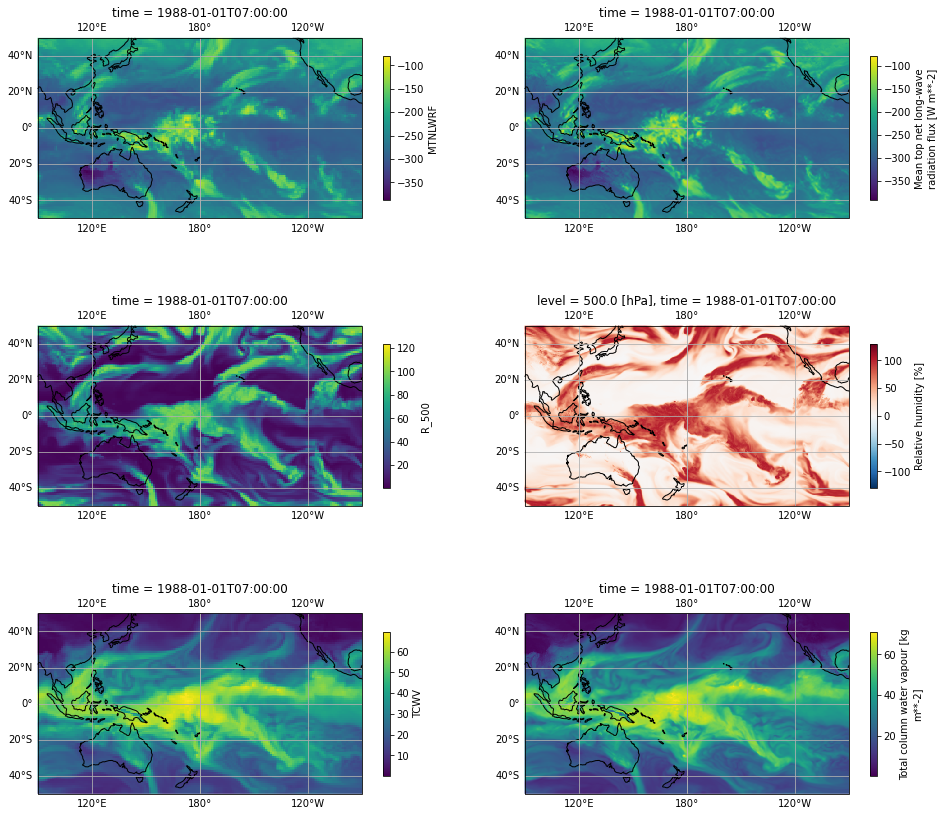

CPU times: user 32.9 s, sys: 4.81 s, total: 37.7 s
Wall time: 1min 37s


In [6]:
%%time

print('plots match')

with LocalCluster(n_workers=8) as cluster, Client(cluster) as client, dask.config.set({'temporary-directory': '/tmp'}):
    era5.plot_2d(dset['MTNLWRF'], mtnlwrf['MTNLWRF'],
                 dset['R_500'], r['R'],
                 dset['TCWV'], tcwv['TCWV'], 
                 time='1988-01-01T07',
                 plevels={'r': 500, 'z': 200},
                 extents=[90, 270, -50, 50])

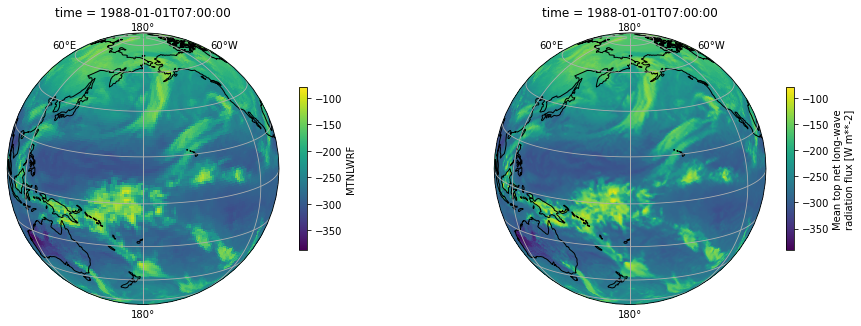

In [7]:
era5.plot_2d(dset['MTNLWRF'], mtnlwrf['MTNLWRF'], time=0,
             subplot_kws={ 'projection': ccrs.Orthographic(180, 15) })